# **Initialization**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
import keras.backend as K
import random
import copy

!pip install shap
import shap

!pip install optuna
import optuna

from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten, Input, Layer, InputSpec, Lambda, Concatenate
from keras.initializers import glorot_uniform, ones, zeros


!git clone https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-.git
import os
os.chdir('/content/Survival-Analysis-Deep-Learning-AML-/Data')

     |████████████████████████████████| 371 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509248 sha256=988a0ddf97c37e7ebc04733eb1e2beecbe9bf02248a7cd9cc2acb0552a1b0aac
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap
     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 209 kB 45.6 MB/s 
     |████████████████████████████████| 75 kB 4.7 MB/s 
     |████████████████████████████████| 149 kB 44.9 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 112 kB 43.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=72d4504229865edfd363b0632188a39a36a4f

# **Data**

In [3]:
gene_names          = pd.read_excel("Data_10_genex_names.xlsx")
patient_data        = pd.read_excel("Table 10.xlsx", index_col="Sample_ID").sort_index()
gene_expression_df  = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
gene_expression_df.columns  = gene_names["gene_names"]

models = []
# scaler          = MinMaxScaler()
scaler          = StandardScaler(with_mean=False, with_std=False)
gene_expression = tf.convert_to_tensor(scaler.fit_transform(gene_expression_df).astype("float32"))

# **Auxiliary functions**

In [4]:
def vis_clus(coordinates, patient_data, var_of_interest):
    coordinates = coordinates.numpy()

    patientdat  = patient_data[var_of_interest]
    labels      = patientdat.astype('category').cat.codes.to_list()
    un_labels   = np.unique(labels)
    num_colors  = len(un_labels)
    colors      = plt.get_cmap('rainbow', num_colors)
    fig         = plt.figure(figsize=(10,10))
    categories  = np.unique(patientdat)
    clusters    = {entity:coordinates[patientdat == entity] for entity in categories}
    num_patients    = coordinates.shape[0]
    for i, entity in enumerate(clusters):
        coords  = clusters[entity]
        label   = "{} ({})".format(entity, round(coords.shape[0]/num_patients*100, ndigits=2))
        cluster = plt.scatter(coords[:,0],coords[:,1],label=label,color=colors(i))
    # plt.ylim((-0.03,0.1))
    # plt.xlim((-0.03,0.13))
    plt.legend(bbox_to_anchor=(1.05, 1))

In [151]:
def vis_shap(shap_values, type_plot, number_features_disp, class_labels, feature_values, size= None, classes =None):

    if classes is None:
        classes = class_labels
    if size is None:
        size = (15,round(1.5*number_features_disp)+1)

    for entity in classes:
        index = list(class_labels).index(entity)
        name = class_labels[index]
        data = shap_values[index]
        plt.title(name, fontsize = 25)
        shap.summary_plot(data, plot_type=p_type, max_display=number_features_disp, plot_size=size, features=np.array(feature_values), feature_names= feature_values.columns, class_names=labels)
        print()

In [5]:
def data_procsg(data_i, data_l, aug_n, batch_size, var_of_interest, balance = False):

    gene_expression_np  = data_i.numpy()
    patientdat          = data_l[var_of_interest]
    labels              = np.sort(np.unique(patientdat))

    var                 = np.var(gene_expression_np, axis = 0)
    
    num_data            = gene_expression_np.shape[1]
    num_entities        = labels.shape[0]
    y_train             = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(patientdat)]))
    
    if balance == True:
        
        categories  = np.unique(patientdat)
        multiplier  = {entity:sum(patientdat == entity) for entity in categories}
        maxi        = max(list(multiplier.values()))
        multiplier  = {entity:round(maxi/multiplier[entity]) for entity in categories}

        gene_expression_balanced   = np.empty(shape=(1,num_data))
        y_labels_balanced          = np.empty(shape=(1,num_entities))

        for i, patient in enumerate(gene_expression_np):

            m = multiplier[patientdat[i]]
            # print(patientdat[i])
            patient         = gene_expression[i]
            label           = y_train[i]
            additions       = np.array([patient for i in range(m)])
            additions_l     = np.array([label for i in range(m)])
            gene_expression_balanced = np.concatenate((gene_expression_balanced, additions))
            y_labels_balanced = np.concatenate((y_labels_balanced, additions_l))
            # print(additions)

        gene_expression_balanced = np.delete(gene_expression_balanced, (0), axis = 0)
        y_labels_balanced        = np.delete(y_labels_balanced, (0), axis = 0)
        # print(y_labels_balanced.shape[1], y_labels_balanced.shape[0])
        gene_expression_np       = gene_expression_balanced
        y_train                  = y_labels_balanced

    # print(multiplier, maxi)


    num_patients        = gene_expression_np.shape[0]
    aa_n = []
    aa_c = []
    aa_labels = []
    for i in range(aug_n):

        num_switch          = np.random.randint(0,num_data)
        switch_dir          = np.ones(num_data)
        switch_dir[:num_switch]  = -1
        np.random.shuffle(switch_dir)

        aa_n.append(gene_expression_np + switch_dir*np.random.normal(loc=0, scale=var/10, size = gene_expression_np.shape))
        aa_c.append(gene_expression_np)
        aa_labels.append(y_train)

    gene_expression_np_noise = np.array(aa_n).reshape(-1, num_data)
    gene_expression_np_clean = np.array(aa_c).reshape(-1, num_data)
    labels_all = np.array(aa_labels).reshape(-1, num_entities)

    data_n = pd.DataFrame(gene_expression_np_noise)
    data_c = pd.DataFrame(gene_expression_np_clean)
    data_y = pd.DataFrame(labels_all)

    num_patients    = data_n.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = tf.convert_to_tensor(data_n.iloc[ind_shuffle][:train_size])
    x_test      = tf.convert_to_tensor(data_n.iloc[ind_shuffle][train_size:])

    x_train_c     = tf.convert_to_tensor(data_c.iloc[ind_shuffle][:train_size])
    x_test_c      = tf.convert_to_tensor(data_c.iloc[ind_shuffle][train_size:])

    y_train     = data_y.iloc[ind_shuffle][:train_size] 
    y_test      = data_y.iloc[ind_shuffle][train_size:]

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train_c, y_train)).batch(batch_size)
    test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, x_test_c, y_test)).batch(batch_size)

    return train_dataset, test_dataset

In [6]:
def plot(history,size = 10):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # plt.subplot(1,2,2)
    # x_axis = np.arange(1, len(history.history['accuracy'])+1)
    # plt.plot(x_axis, history.history['accuracy'], label='training')
    # plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    # plt.title('Training and validation accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend(loc='lower right')

    return fig

In [7]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        print(" This is the best trial so far")
        #study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        study.set_user_attr(key="train_loss", value=trial.user_attrs["train_loss"])
        study.set_user_attr(key="test_loss", value=trial.user_attrs["test_loss"])
        # study.set_user_attr(key="history", value=trial.user_attrs["history"])

In [8]:
def classification_f(index, L):
    classifiction = list(np.zeros(L-1))
    classifiction.insert(index, 1)
    return classifiction

In [9]:
def Heatmap_Clustering(soft_labels, patient_data, var_of_interest):

    num_clusters        = len(soft_labels[0][:])
    clusters            = ["c{}".format(i+1) for i in range(num_clusters)]
    soft_labels         = pd.DataFrame(soft_labels.numpy(), columns = clusters)
    patient_data_cat    = pd.DataFrame(patient_data[var_of_interest])
    soft_labels_cat     = patient_data_cat.join(soft_labels)
    patient_labels      = np.unique(patient_data_cat)
    num_categories      = len(patient_labels)

    heatmap_data = pd.DataFrame(index = patient_labels, columns = clusters, dtype= "float32")
    # heatmap_data    = np.empty(shape=(num_categories, num_clusters))

    for i, entity in enumerate(patient_labels):

        cluster                     = soft_labels_cat[soft_labels_cat[var_of_interest]==entity]
        del cluster[var_of_interest]

        num_patients                = len(cluster)
        average_label_assignment    = np.sum(cluster, axis = 0) / num_patients
        heatmap_data.loc[entity]    = average_label_assignment
    
    heatmap_figure      = plt.figure(figsize=(15,12))
    heatmap             = sns.heatmap(heatmap_data, annot= True, fmt= ".4f")

In [10]:
def tSNE_plot(coords, var_of_interest):
    
    tsne = TSNE(2, perplexity = 20, verbose=1, random_state = 69)
    tsne_coordinates = tsne.fit_transform(coords)

    patientdat = patient_data[var_of_interest]
    labels = patientdat.astype('category').cat.codes.to_list()
    num_colors = len(np.unique(labels))
    colors = plt.get_cmap('rainbow', num_colors)

    fig_tsne = plt.figure(figsize= (10,10))
    plt.scatter(tsne_coordinates[:,0], tsne_coordinates[:,1], c= colors(labels))
    plt.legend()

In [11]:
def vis_dif(input, output):
    difference = abs(input - output).numpy()
    difference = difference.reshape(input.shape[0]*input.shape[1])
    # difference[difference > 1] = 1
    figure     = plt.figure(figsize=(15,12))
    plt.subplot(1,2,1)
    plt.boxplot(difference, showmeans = True)
    plt.subplot(1,2,2)
    plt.hist(difference, bins = 35)

In [12]:
def normalize(X):
    X = X/K.max(K.abs(X),axis=0)
    return X

In [168]:
def plot_VAE(train_loss, test_loss, accuracy):
     
    fs          = 25
    total       = train_loss[:,0]
    total       = np.array((total,total,total)).T
    ratio_train = train_loss[:,1:]/total
    ratio_train = pd.DataFrame(ratio_train, columns= ["kl ratio", "reconstruction ratio", "classification ratio"])

    total       = test_loss[:,0]
    total       = np.array((total,total,total)).T
    ratio_test  = test_loss[:,1:]/total
    ratio_test  = pd.DataFrame(ratio_test, columns= ["kl ratio", "reconstruction ratio", "classification ratio"])

    train_loss  = pd.DataFrame(train_loss, columns= ["total loss", "kl loss", "reconstruction loss", "classification loss"])
    test_loss   = pd.DataFrame(test_loss, columns= ["total loss", "kl loss", "reconstruction loss", "classification loss"])
    # print(train_loss, test_loss)

    losses   = list(train_loss.columns)
    maxi    = [max( max(test_loss[loss]), max(train_loss[loss])) for loss in losses]
    mini    = [min( min(test_loss[loss]), min(train_loss[loss])) for loss in losses]

    fig1 = plt.figure(figsize=(25,10))

    plt.subplot(1,2,1)

    total_loss_test      = plt.gca()
    AE_loss_test         = total_loss_test.twinx()
    kl_loss_test         = total_loss_test.twinx()
    c_loss_test          = total_loss_test.twinx()

    kl_loss_test.spines["right"].set_position(("axes", 1.2))
    c_loss_test.spines["right"].set_position(("axes", 1.4))

    colors = plt.get_cmap('Reds', 5)

    total_test,     = total_loss_test.plot(test_loss["total loss"], label = 'Total', color = colors(2))
    total_loss_test.set_ylim(mini[0], maxi[0])
    total_loss_test.set_xlabel("Epochs")
    total_loss_test.set_ylabel("Total loss")
    total_loss_test.yaxis.label.set_color("red")
    total_loss_test.tick_params(axis = "y", colors = "red")
    total_loss_test.spines["right"].set_color("red")

    colors = plt.get_cmap('Blues', 3)

    kl_test,        = kl_loss_test.plot(test_loss["kl loss"], label = 'KL divergence', color = colors(1))
    kl_loss_test.set_ylim(mini[1], maxi[1])
    kl_loss_test.set_ylabel("KL loss")
    kl_loss_test.yaxis.label.set_color("dodgerblue")
    kl_loss_test.tick_params(axis = "y", colors = "dodgerblue")
    kl_loss_test.spines["right"].set_color("dodgerblue")

    colors = plt.get_cmap('Greens', 3)

    AE_test,        = AE_loss_test.plot(test_loss["reconstruction loss"], label = 'Reconstruction', color = colors(1))
    AE_loss_test.set_ylim(mini[2], maxi[2])
    AE_loss_test.set_ylabel("Reconstruction loss")
    AE_loss_test.yaxis.label.set_color("green")
    AE_loss_test.tick_params(axis = "y", colors = "green")
    AE_loss_test.spines["right"].set_color("green")

    colors = plt.get_cmap('Purples', 3)

    c_test,        = c_loss_test.plot(test_loss["classification loss"], label = 'Classification', color = colors(1))
    c_loss_test.set_ylim(mini[3], maxi[3])
    c_loss_test.set_ylabel("Classification loss")
    c_loss_test.yaxis.label.set_color("purple")
    c_loss_test.tick_params(axis = "y", colors = "purple")
    c_loss_test.spines["right"].set_color("purple")

    curves          = [total_test, AE_test, kl_test, c_test]
    total_loss_test.legend(curves, [curve.get_label() for curve in curves])
    plt.title("Test loss", fontsize=fs)
    # fig2 = plt.figure(figsize=(10,10))

    plt.subplot(1,2,2)

    total_loss      = plt.gca()
    AE_loss         = total_loss.twinx()
    kl_loss         = total_loss.twinx()
    c_loss          = total_loss.twinx()

    kl_loss.spines["right"].set_position(("axes", 1.2))
    c_loss.spines["right"].set_position(("axes", 1.4))

    total_train,    = total_loss.plot(train_loss["total loss"], label = 'Total', color = "red")
    total_loss.set_ylim(mini[0], maxi[0])
    total_loss.set_xlabel("Epochs")
    total_loss.set_ylabel("Total loss")
    total_loss.yaxis.label.set_color("red")
    total_loss.tick_params(axis = "y", colors = "red")
    total_loss.spines["right"].set_color("red")

    kl_train,       = kl_loss.plot(train_loss["kl loss"], label = 'KL divergence', color = "dodgerblue")
    kl_loss.set_ylim(mini[1], maxi[1])
    kl_loss.set_ylabel("KL loss")
    kl_loss.yaxis.label.set_color("dodgerblue")
    kl_loss.tick_params(axis = "y", colors = "dodgerblue")
    kl_loss.spines["right"].set_color("dodgerblue")

    AE_train,       = AE_loss.plot(train_loss["reconstruction loss"], label = 'Reconstruction', color = "green")
    AE_loss.set_ylim(mini[2], maxi[2])
    AE_loss.set_ylabel("Reconstruction loss")
    AE_loss.yaxis.label.set_color("green")
    AE_loss.tick_params(axis = "y", colors = "green")
    AE_loss.spines["right"].set_color("green")

    c_train,       = c_loss.plot(train_loss["classification loss"], label = 'Classification', color = "purple")
    c_loss.set_ylim(mini[3], maxi[3])
    c_loss.set_ylabel("Classification loss")
    c_loss.yaxis.label.set_color("purple")
    c_loss.tick_params(axis = "y", colors = "purple")
    c_loss.spines["right"].set_color("purple")

    curves          = [total_train, AE_train, kl_train, c_train]
    total_loss.legend(curves, [curve.get_label() for curve in curves])
    plt.title("Train loss", fontsize=fs)

    fig3    = plt.figure(figsize=(25,15))

    plt.subplot(1,2,1)

    colors = plt.get_cmap('Greens', 3)
    ratio_AE   = plt.plot(ratio_train["reconstruction ratio"], label = "Recontruction", color = colors(1))

    colors = plt.get_cmap('Blues', 3)
    ratio_kl   = plt.plot(ratio_train["kl ratio"], label = "KL divergence", color = colors(1))

    colors = plt.get_cmap('Purples', 3)
    ratio_c    = plt.plot(ratio_train["classification ratio"], label = "Classification", color = colors(1))
    plt.xlabel("Epochs")
    plt.ylabel("Ratio")
    plt.legend()
    plt.title("Loss ratio - test", fontsize=fs)

    plt.subplot(1,2,2)

    ratio_AE   = plt.plot(ratio_train["reconstruction ratio"], label = "Recontruction", color = "green")
    ratio_kl   = plt.plot(ratio_train["kl ratio"], label = "KL divergence", color = "blue")
    ratio_c    = plt.plot(ratio_train["classification ratio"], label = "Classification", color = "purple")

    plt.xlabel("Epochs")
    plt.ylabel("Ratio")
    plt.legend()
    plt.title("Loss ratio - train", fontsize=fs)

    fig4    = plt.figure(figsize=(10,10))

    train_acc    = plt.plot(accuracy[0], label = "Training")
    test_acc     = plt.plot(accuracy[1], label = "Test")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Classification ratio", fontsize=fs)
    plt.ylim((0,1))




In [14]:
def plot_VAE_2(train_loss, test_loss, size = 10):

    total       = train_loss[:,0]
    total        = np.array((total,total)).T
    ratio_train = train_loss[:,1:]/total
    ratio_train = pd.DataFrame(ratio_train, columns= ["kl ratio", "reconstruction ratio"])

    total       = test_loss[:,0]
    total       = np.array((total,total)).T
    ratio_test  = test_loss[:,1:]/total
    ratio_test  = pd.DataFrame(ratio_test, columns= ["kl ratio", "reconstruction ratio"])

    train_loss  = pd.DataFrame(train_loss, columns= ["total loss", "kl loss", "reconstruction loss"])
    test_loss   = pd.DataFrame(test_loss, columns= ["total loss", "kl loss", "reconstruction loss"])
    # print(train_loss, test_loss)

    losses   = list(train_loss.columns)
    maxi    = [max( max(test_loss[loss]), max(train_loss[loss])) for loss in losses]
    mini    = [min( min(test_loss[loss]), min(train_loss[loss])) for loss in losses]

    fig1 = plt.figure(figsize=(10,10))

    total_loss      = plt.gca()
    AE_loss         = total_loss.twinx()
    kl_loss         = total_loss.twinx()

    kl_loss.spines["right"].set_position(("axes", 1.2))

    colors = plt.get_cmap('Reds', 5)

    total_test,     = total_loss.plot(test_loss["total loss"], label = 'Total', color = colors(2))
    total_loss.set_ylim(mini[0], maxi[0])
    total_loss.set_xlabel("Epochs")
    total_loss.set_ylabel("Total loss")
    total_loss.yaxis.label.set_color("red")
    total_loss.tick_params(axis = "y", colors = "red")
    total_loss.spines["right"].set_color("red")

    colors = plt.get_cmap('Blues', 3)

    kl_test,        = kl_loss.plot(test_loss["kl loss"], label = 'KL divergence', color = colors(1))
    kl_loss.set_ylim(mini[1], maxi[1])
    kl_loss.set_ylabel("KL loss")
    kl_loss.yaxis.label.set_color("dodgerblue")
    kl_loss.tick_params(axis = "y", colors = "dodgerblue")
    kl_loss.spines["right"].set_color("dodgerblue")

    colors = plt.get_cmap('Greens', 3)

    AE_test,        = AE_loss.plot(test_loss["reconstruction loss"], label = 'Reconstruction', color = colors(1))
    AE_loss.set_ylim(mini[2], maxi[2])
    AE_loss.set_ylabel("Reconstruction loss")
    AE_loss.yaxis.label.set_color("green")
    AE_loss.tick_params(axis = "y", colors = "green")
    AE_loss.spines["right"].set_color("green")

    curves          = [total_test, AE_test, kl_test]
    total_loss.legend(curves, [curve.get_label() for curve in curves])

    fig2 = plt.figure(figsize=(10,10))

    total_loss      = plt.gca()
    AE_loss         = total_loss.twinx()
    kl_loss         = total_loss.twinx()

    kl_loss.spines["right"].set_position(("axes", 1.2))

    total_train,    = total_loss.plot(train_loss["total loss"], label = 'Total', color = "red")
    total_loss.set_ylim(mini[0], maxi[0])
    total_loss.set_xlabel("Epochs")
    total_loss.set_ylabel("Total loss")
    total_loss.yaxis.label.set_color("red")
    total_loss.tick_params(axis = "y", colors = "red")
    total_loss.spines["right"].set_color("red")

    kl_train,       = kl_loss.plot(train_loss["kl loss"], label = 'KL divergence', color = "dodgerblue")
    kl_loss.set_ylim(mini[1], maxi[1])
    kl_loss.set_ylabel("KL loss")
    kl_loss.yaxis.label.set_color("dodgerblue")
    kl_loss.tick_params(axis = "y", colors = "dodgerblue")
    kl_loss.spines["right"].set_color("dodgerblue")

    AE_train,       = AE_loss.plot(train_loss["reconstruction loss"], label = 'Reconstruction', color = "green")
    AE_loss.set_ylim(mini[2], maxi[2])
    AE_loss.set_ylabel("Reconstruction loss")
    AE_loss.yaxis.label.set_color("green")
    AE_loss.tick_params(axis = "y", colors = "green")
    AE_loss.spines["right"].set_color("green")

    curves          = [total_train, AE_train, kl_train]
    total_loss.legend(curves, [curve.get_label() for curve in curves])

    fig3    = plt.figure(figsize=(25,15))

    plt.subplot(1,2,1)

    colors = plt.get_cmap('Greens', 3)
    ratio_AE   = plt.plot(ratio_train["reconstruction ratio"], label = "Recontruction", color = colors(1))

    colors = plt.get_cmap('Blues', 3)
    ratio_kl   = plt.plot(ratio_train["kl ratio"], label = "KL divergence", color = colors(1))

    plt.xlabel("Epochs")
    plt.ylabel("Ratio")
    plt.legend()

    plt.subplot(1,2,2)

    ratio_AE   = plt.plot(ratio_train["reconstruction ratio"], label = "Recontruction", color = "green")
    ratio_kl   = plt.plot(ratio_train["kl ratio"], label = "KL divergence", color = "blue")

    plt.xlabel("Epochs")
    plt.ylabel("Ratio")
    plt.legend()

# **Clustering**

## Clustering layer

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def add_cluslayer(model, data, d):

    input_size  = data.shape[1]
    encoder_cluster   = tf.keras.models.clone_model(model)
    encoder_cluster.build(input_shape = (None, input_size))
    encoder_cluster.set_weights(model.get_weights())

    kmeans      = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder_cluster.predict(data))
    encoder_cluster.add(ClusteringLayer(d, name = "cluster"))

    encoder_cluster.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    #encoder_cluster.build(input_shape= (None,input_size))

    return encoder_cluster

# **Auto-encoding (DEC)**

In [ ]:
def Auto_encoder(input_size, structure):
    
    hidden_layers   = structure['hidden layers']
    embedding_size  = structure['embedding layer']
    activation      = structure['activation']
    drop            = structure["dropout rate"]

    structure       = hidden_layers + [embedding_size] + hidden_layers[::-1]
    
    coder_length    = len(hidden_layers)

    model           = Sequential(name = "Auto-encoder")

    model.add(Input(shape   = (input_size,), 
                    name    = "Input"))
    
    names           = ["Encoding_layer-"]*coder_length + ["Embedding_layer"] + ["Decoding_layer-"]*coder_length
    numbers         = np.concatenate((np.array(range(coder_length)) + 1, np.array(range(coder_length))+1)).tolist()

    numbers.insert(coder_length, "")

    for i,j in enumerate(structure):
        model.add(Dense(j,
                        kernel_initializer  = glorot_uniform(),
                        activation          = activation,
                        name                = "{}{}".format(names[i],numbers[i]))
        )
        model.add(Dropout(drop,
                          name = "Dropout-{}".format(i+1)))
    
    model.add(Dense(input_size,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")
    )

    return model


In [ ]:
def par_tuner(trial):

    global gene_expression, models

    #gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
    # gene_expression = gene_expression.astype("float32")
    input_dim       = gene_expression.shape[1]

    scaler = MinMaxScaler()
    gene_expression = pd.DataFrame(scaler.fit_transform(gene_expression))

    num_patients    = gene_expression.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = gene_expression.iloc[ind_shuffle][:train_size]
    x_test      = gene_expression.iloc[ind_shuffle][train_size:]

    gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    embedding_layer = trial.suggest_int("embedding layer size", 10, 50)
    activation      = trial.suggest_categorical("activation", ["relu", "selu"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 1)
    momentum        = trial.suggest_float("momentum", 0, 0.999)

    tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum)

    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 2000)
        hidden_layers.append(hlayer)

    structure = {"hidden layers"    :   hidden_layers,
                 "embedding layer"  :   embedding_layer,
                 "activation"       :   activation,
                 "dropout rate"     :   dropout_rate}

    model = Auto_encoder(input_dim, structure)

    model.compile(loss      = "mse", 
                  optimizer = optimizer,
                  metrics   = ["accuracy"])

    history = model.fit(x_train, 
                        x_train,
                        epochs          = 100,
                        validation_data = (x_test,x_test),
                        verbose = False)
    
    global models
    models.append(model)

    loss, accuracy    = model.evaluate(x_test,x_test, verbose = False)

    # if trial.number == 0:
    #     trial.set_user_attr("Best model", model)
    # elif loss < trial.user_attrs[1]:
    #     trial.set_user_attr("Best model", model)
    # trial.set_user_attr(key="best_booster", value=model)
    # print(trial.user_attrs)
    plot(history,10)

    return loss

In [ ]:
def find_autoencoder(n,d):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning auto-encoder")
    study.optimize(par_tuner, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    n_encoding_layers   = trial.params["N_layers"] 
    encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    encoder             = Sequential(encoding_layers) 

    
    kmeans = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder.predict(gene_expression))
    encoder.add(ClusteringLayer(d, name = "cluster"))

    encoder.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    encoder.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial, autoencoder, encoder

## Training

In [ ]:
def training(model, epochs, data = gene_expression):

    @tf.function(experimental_relax_shapes=True)
    def trainstep(model, x_train, optimizer):

        with tf.GradientTape() as tape:

            q       = model(x_train, training= True)
            p       = K.square(q) / K.sum(q, axis=0)
            p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
            loss    = K.sum(p*K.log(p/q))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return loss

    @tf.function(experimental_relax_shapes=True)
    def teststep(model, x_test, optimizer):

        q       = model(x_test, training= False)
        p       = K.square(q) / K.sum(q, axis=0)
        p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
        loss    = K.sum(p*K.log(p/q))

        return loss

    input_dim       = data.shape[1]

    scaler  = MinMaxScaler()
    data    = pd.DataFrame(scaler.fit_transform(data))

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = data.iloc[ind_shuffle][:train_size]
    x_test      = data.iloc[ind_shuffle][train_size:]

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    optimizer = keras.optimizers.SGD(learning_rate= 0.01)
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = []
    loss_test   = []

    for i in range(epochs):

        train_loss  = trainstep(model, x_train, optimizer)
        loss_train.append(train_loss)
        test_loss   = teststep(model, x_test, optimizer)
        loss_test.append(test_loss)

    return model, loss_train, loss_test


[I 2021-11-08 12:59:49,720] A new study created in memory with name: Tuning auto-encoder
[I 2021-11-08 13:00:03,856] Trial 0 finished with value: 0.034803666174411774 and parameters: {'N_layers': 3, 'embedding layer size': 12, 'activation': 'relu', 'optimizer': 'adam', 'dropout rate': 0.23508359166365472, 'learning rate': 0.6005855906600195, 'momentum': 0.6284315281876139, 'hlay 1': 1631, 'hlay 2': 467, 'hlay 3': 937}. Best is trial 0 with value: 0.034803666174411774.


 This is the best trial so far


KeyError: ignored

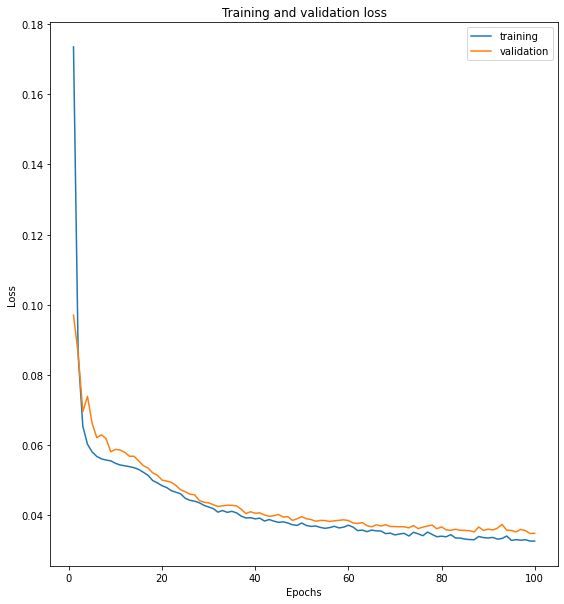

In [ ]:
var_of_interest     = "Transcriptional_Identity"
trial, autoencoder, encoder = find_autoencoder(1,10)
coords  = encoder(gene_expression, training = False)
# tSNE_plot(coords, var_of_interest)

In [ ]:
# @tf.function(experimental_relax_shapes=True)
# def trainstep(model, x_train, optimizer):

#     with tf.GradientTape() as tape:

#         q       = model(x_train, training= True)
#         p       = K.square(q) / K.sum(q, axis=0)
#         p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
#         loss    = K.sum(p*K.log(p/q))

#     grads = tape.gradient(loss, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))

#     return loss

# @tf.function(experimental_relax_shapes=True)
# def teststep(model, x_test, optimizer):

#     q       = model(x_test, training= False)
#     p       = K.square(q) / K.sum(q, axis=0)
#     p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
#     loss    = K.sum(p*K.log(p/q))

#     return loss

data        = gene_expression

# encoder_cluster     = add_cluslayer(encoder, data, 13)

var_of_interest = "Transcriptional_Identity"
results         = encoder(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

input_size  = data.shape[1]
encoder_2   = tf.keras.models.clone_model(encoder)
encoder_2.build(input_shape = (None, input_size))
# encoder_2.set_weights(encoder_cluster.get_weights())
# encoder_2.summary()

encoder_2, train_loss, test_loss    = training(encoder_2, 100)

results         = encoder_2(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

fig = plt.figure(figsize=(10,10))
plt.plot(train_loss, label = 'train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()

# **VAE**

## Building VAE

In [159]:
def sampling(args):
    z_mean, z_log_sigma = args
    latent_dim = K.shape(z_mean)
    epsilon = K.random_normal(shape=(latent_dim[0], latent_dim[1]),
                              mean=0., stddev=0.01)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [160]:
def VAE(structure):

    # K.clear_session()
    # test            = tf.keras.activations.relu(threshold=0.00001)
    input_dim       = structure["input dimension"]
    hidden_layers_e = structure["hidden layers"]
    hidden_layers_d = hidden_layers_e[::-1]
    latent_dim      = structure["latent dimension size"]

    activation      = structure["activation"]
    drop            = structure["dropout rate"]
    optimizer       = structure["optimizer"]
    lr              = structure["learning rate"]
    n_cluster       = structure["number of clusters"]      

    input_e         = Input(shape   = (input_dim,), 
                            name    = "Input")
    input_d         = Input(shape   = (latent_dim,), 
                            name    = "Input")
    
    coder_length    = len(hidden_layers_e)
    names_e         = ["Encoding_layer_"]*coder_length
    names_d         = ["Decoding_layer_"]*coder_length


    hidden_layer_e  = Dense(hidden_layers_e[0],
                            kernel_initializer  = None, #glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_e[0], 1))(input_e)
    hidden_layer_d  = Dense(hidden_layers_d[0],
                            kernel_initializer  = None, #glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_d[0], 1))(input_d)


    hidden_layers_e.pop(0)
    hidden_layers_d.pop(0)

    for i in range(len(hidden_layers_e)):
        hidden_layer_e    = Dense(hidden_layers_e[i],
                                kernel_initializer  = None, #glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_e[i], i+2))(hidden_layer_e)
        hidden_layer_d    = Dense(hidden_layers_d[i],
                                kernel_initializer  = None, #glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_d[i], i+2))(hidden_layer_d)
    
    mean        = Dense(latent_dim,
                        kernel_initializer  = None, #glorot_uniform(),
                        activation          = None,
                        name                = "z_mean")(hidden_layer_e)
    log_sigma   = Dense(latent_dim,
                        kernel_initializer  = None, #glorot_uniform(),
                        activation          = None,
                        name                = "z_log_sigma")(hidden_layer_e)
    # sigma_a = Activation(Lambda(lambda x: tf.keras.activations.relu(x, threshold=5)))(sigma)               
    z       = Lambda(sampling, name = "Sampling")([mean, log_sigma])

    # classification  = Dense(n_cluster,
    #                         kernel_initializer  = None,
    #                         activation          = "softmax",
    #                         name                = "classification_layer")(z)

    output  = Dense(input_dim,
                    kernel_initializer  = None, #glorot_uniform(),
                    activation          = "linear",
                    name                = "Output")(hidden_layer_d)     

    # K.clear_session()  
    encoder     = Model(inputs  = input_e, 
                        outputs = [mean, log_sigma, z], 
                        name    = "VAE-encoder")
    decoder     = Model(inputs  = input_d, 
                        outputs = output, 
                        name    = "VAE-decoder")
    
    inputs      = Input(shape   = (input_dim,), 
                        name    = "Input")
    outputs     = decoder(encoder(input_e)[2])
    autoencoder = keras.Model(inputs    = input_e, 
                      outputs   = outputs, 
                      name      = "VAE")
    
    # reconstruction_loss = keras.losses.MeanSquaredError()
    # classification_loss = keras.losses.CategoricalCrossentropy()
    # kl_loss = 1 + 2 * log_sigma - K.square(mean) - K.square(K.exp(log_sigma))
    # kl_loss = K.sum(kl_loss, axis=-1)
    # kl_loss *= -0.5
    # vae_loss = K.mean(reconstruction_loss(input_e, outputs) + kl_loss)
    # autoencoder.add_loss(vae_loss)
    # autoencoder.compile(optimizer = optimizer)
    # autoencoder.add_loss(lambda : 10)
    # classification.add_loss(lambda : classification_loss(y_train, classification))
    encoder.compile(optimizer=optimizer)
    K.set_value(encoder.optimizer.learning_rate, lr)
    decoder.compile(optimizer=optimizer)
    K.set_value(decoder.optimizer.learning_rate, lr)
    # K.clear_session()  
    return encoder, decoder, autoencoder

## Training

### Hyperparameter tuning functions

In [22]:
def hyperpar_tuner_VAE(trial):

    K.clear_session()

    global gene_expression, models, num_labels, train_dataset, test_dataset, epochs

    # patient_data_cat    = patient_data[var_of_interest]
    # labels              = np.sort(np.unique(patient_data_cat))

    input_dim       = gene_expression.shape[1]

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    latent_dim      = 2 #trial.suggest_int("latent dimension size", 2, 15)
    activation      = trial.suggest_categorical("activation", ["relu", "selu", "tanh"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = 0 #trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 10**-2)
    # momentum        = trial.suggest_float("momentum", 0, 0.999)

    # if optimizer == "adam":
    #     optimizer   = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum, clipnorm = 1)
    # else:
    #     optimizer   = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum, clipnorm = 1)

    


    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 500)
        hidden_layers.append(hlayer)

    structure = {"input dimension"        :   input_dim,
                 "hidden layers"          :   hidden_layers,
                 "latent dimension size"  :   latent_dim,
                 "activation"             :   activation,
                 "dropout rate"           :   dropout_rate,
                 "learning rate"          :   learning_rate,
                 "optimizer"              :   optimizer,
                 "number of clusters"     :   num_labels}
    


    # data    = pd.DataFrame(gene_expression.numpy())

    # num_patients    = data.shape[0]
    # ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    # train_size      = int(0.80*num_patients) 

    # x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    # y_train     = tf.convert_to_tensor(patient_data_cat.iloc[ind_shuffle][:train_size])
    # y_train     = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(y_train)]))
    # x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])

    encoder, decoder, autoencoder       = VAE(structure)

    loss_train, loss_test = training_VAE(encoder, decoder, epochs, train_dataset, test_dataset)


    # autoencoder.build(input_shape=(None,input_dim))
    # autoencoder.summary()

    # history = autoencoder.fit(x                 = x_train, 
    #                           y                 = x_train,
    #                           epochs            = 200,
    #                           verbose           = 0,
    #                           validation_data   = (x_test, x_test))
    
    # trial.set_user_attr(key="history", value = history)
    trial.set_user_attr(key="test_loss", value = loss_test)
    trial.set_user_attr(key="train_loss", value = loss_train)

    result  = loss_test[-1]

    # autoencoder, train_loss, test_loss  = training_VAE_trial(autoencoder, 500, optimizer, trial)

    models.append(autoencoder)
    # result                              = test_loss[-1, 0]
    # plot_VAE(train_loss, test_loss)

    return result


In [23]:
def find_VAE(n):

    global models
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning VAE")
    study.optimize(hyperpar_tuner_VAE, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    encoder     = Model(inputs  = autoencoder.input,
                            outputs = autoencoder.get_layer("VAE-encoder").output)


    # n_encoding_layers   = trial.params["N_layers"] 
    # encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    # encoder             = Sequential(encoding_layers) 

    
    # kmeans = KMeans(n_clusters= d, n_init=20)
    # kmeans.fit_predict(encoder_DEC.predict(gene_expression)[-1])
    # clustering_layer  = ClusteringLayer(d, name = "cluster")(encoder_DEC.output[-1])
    # encoder_DEC     = Model(inputs  = encoder_DEC.input,
    #                         outputs = clustering_layer)

    # encoder_DEC.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    # encoder_DEC.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return trial, autoencoder, encoder

### Training loop

In [161]:
def training_VAE(encoder, decoder, epochs, train_dataset, test_dataset):

    @tf.function 
    def trainstep(encoder, decoder, train_data, mse):

        x_train     = train_data[0]
        y_train     = train_data[1]
        y_labels    = train_data[2]

        with tf.GradientTape() as tape:

            (z_mean, z_log_sigma, z) = encoder(x_train, training = True)
            reconstruction = decoder(z, training = True)

            kl_loss = K.sum(K.sum(-0.5 - z_log_sigma + 0.5 * K.square(z_mean) + 0.5 * K.square(K.exp(z_log_sigma)), axis=-1), axis =-1) / 512
            r_loss = mse(y_train, reconstruction)

            loss = kl_loss + r_loss

        grads = tape.gradient(loss, [encoder.trainable_weights, decoder.trainable_weights])
        encoder.optimizer.apply_gradients(zip(grads[0], encoder.trainable_weights))
        decoder.optimizer.apply_gradients(zip(grads[1], decoder.trainable_weights))

        return loss, kl_loss, r_loss

    @tf.function
    def teststep(encoder, decoder, test_data, mse):

        x_test      = test_data[0]
        y_test      = test_data[1]
        y_labels    = test_data[2]

        (z_mean, z_log_sigma, z) = encoder(x_test, training = False)
        reconstruction = decoder(z, training = False)

        kl_loss = K.sum(K.sum(-0.5 - z_log_sigma + 0.5 * K.square(z_mean) + 0.5 * K.square(K.exp(z_log_sigma)), axis=-1), axis =-1) / 512
        r_loss = mse(y_test, reconstruction)

        loss = kl_loss + r_loss

        return loss, kl_loss, r_loss
    # print(data)
    # input_dim       = data_n.shape[1]]
    # num_patients    = data.shape[0]
    # ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    # train_size      = int(0.80*num_patients) 

    # input_dim       = data.shape[1]

    # data    = pd.DataFrame(data.numpy())
    # data    = pd.DataFrame(normalize(data).numpy())

    # num_patients    = data.shape[0]
    # ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    # train_size      = int(0.80*num_patients) 

    # x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    # x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])


    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    # optimizer = keras.optimizers.Adam(learning_rate= 0.00001, clipnorm = 1)
    mse       = keras.losses.MeanSquaredError()
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = np.empty(shape=(epochs,3))
    loss_test   = np.empty(shape=(epochs,3))

    # encoder         = Model(inputs  = model.input,
    #                         outputs = model.get_layer("VAE-encoder").output)

    pgs =  tqdm(range(epochs))
    for i in pgs:

        for train_batch in train_dataset:
            train_loss      = trainstep(encoder, decoder, train_batch, mse)
            loss_train[i]   = train_loss
        for test_batch in test_dataset:
            test_loss       = teststep(encoder, decoder, test_batch, mse)
            loss_test[i]    = test_loss

        pgs.set_description("Training & test loss at epoch %d: %.4f: & %.4f" % (i,float(train_loss[0]),float(test_loss[0])))

    return loss_train, loss_test

### With hyperparameter tuning

In [25]:
var_of_interest     = "Transcriptional_Identity"
patient_data_cat    = patient_data[var_of_interest]
num_labels          = len(np.sort(np.unique(patient_data_cat)))
batch_size          = 512
epochs              = 100

train_dataset, test_dataset = data_procsg(gene_expression, patient_data, 15, batch_size, var_of_interest, balance=True)

best_trial, vae, encoder    = find_VAE(12)

coords      = encoder(gene_expression)[-1]
vis_clus(coords, patient_data, var_of_interest)

loss_train  = best_trial.user_attrs["train_loss"]
loss_test   = best_trial.user_attrs["test_loss"]
plot_VAE_2(loss_train, loss_test)

[I 2021-11-25 11:03:59,591] A new study created in memory with name: Tuning VAE
Training & test loss at epoch 12: nan: & nan:  13%|█▎        | 13/100 [00:08<00:58,  1.50it/s]


KeyboardInterrupt: ignored

### Without hyperparamter tuning

Training & test loss at epoch 999: 1.3731: & 1.8614: 100%|██████████| 1000/1000 [01:59<00:00,  8.35it/s]


Train losses : total = 1.3731 | kl divergence  = 0.0259 | reconstruction = 1.3472
Test losses  : total = 1.8614 | kl divergence  = 0.0307 | reconstruction = 1.8307


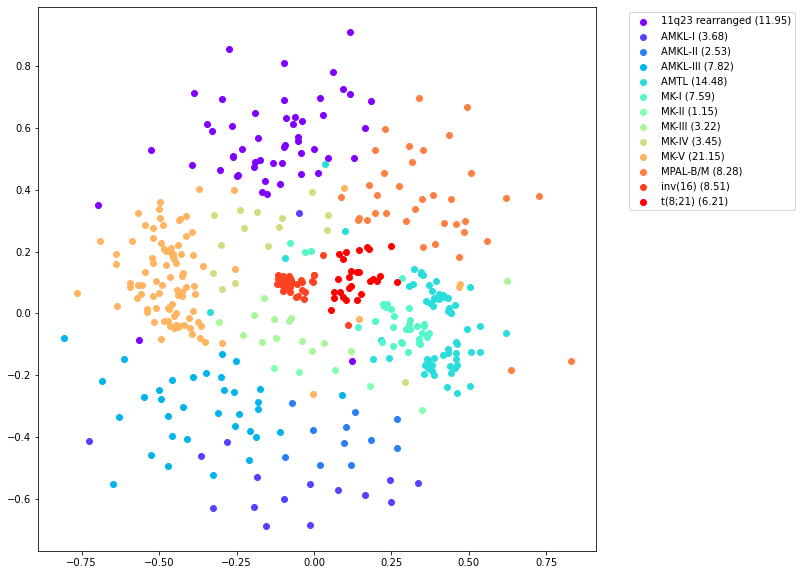

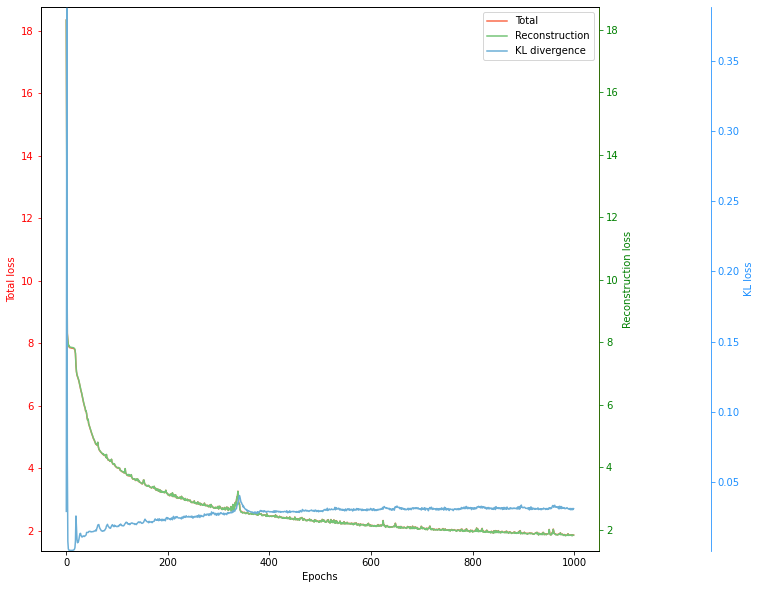

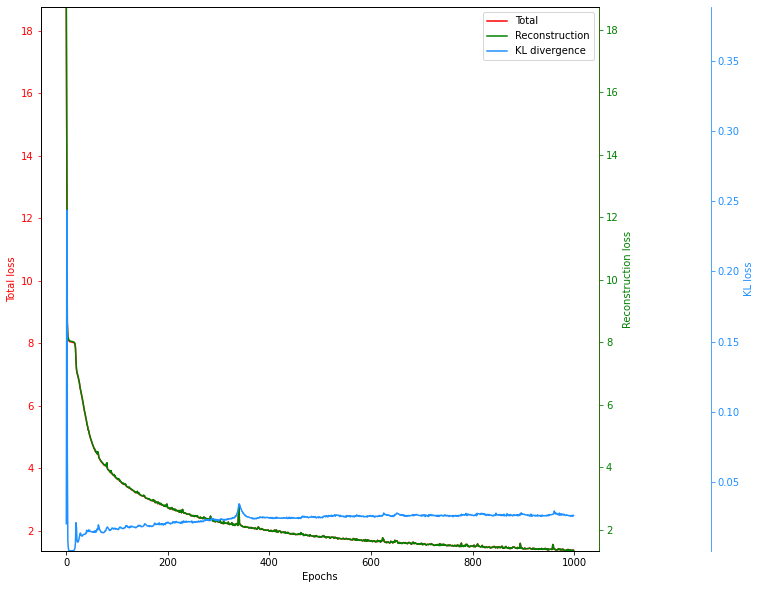

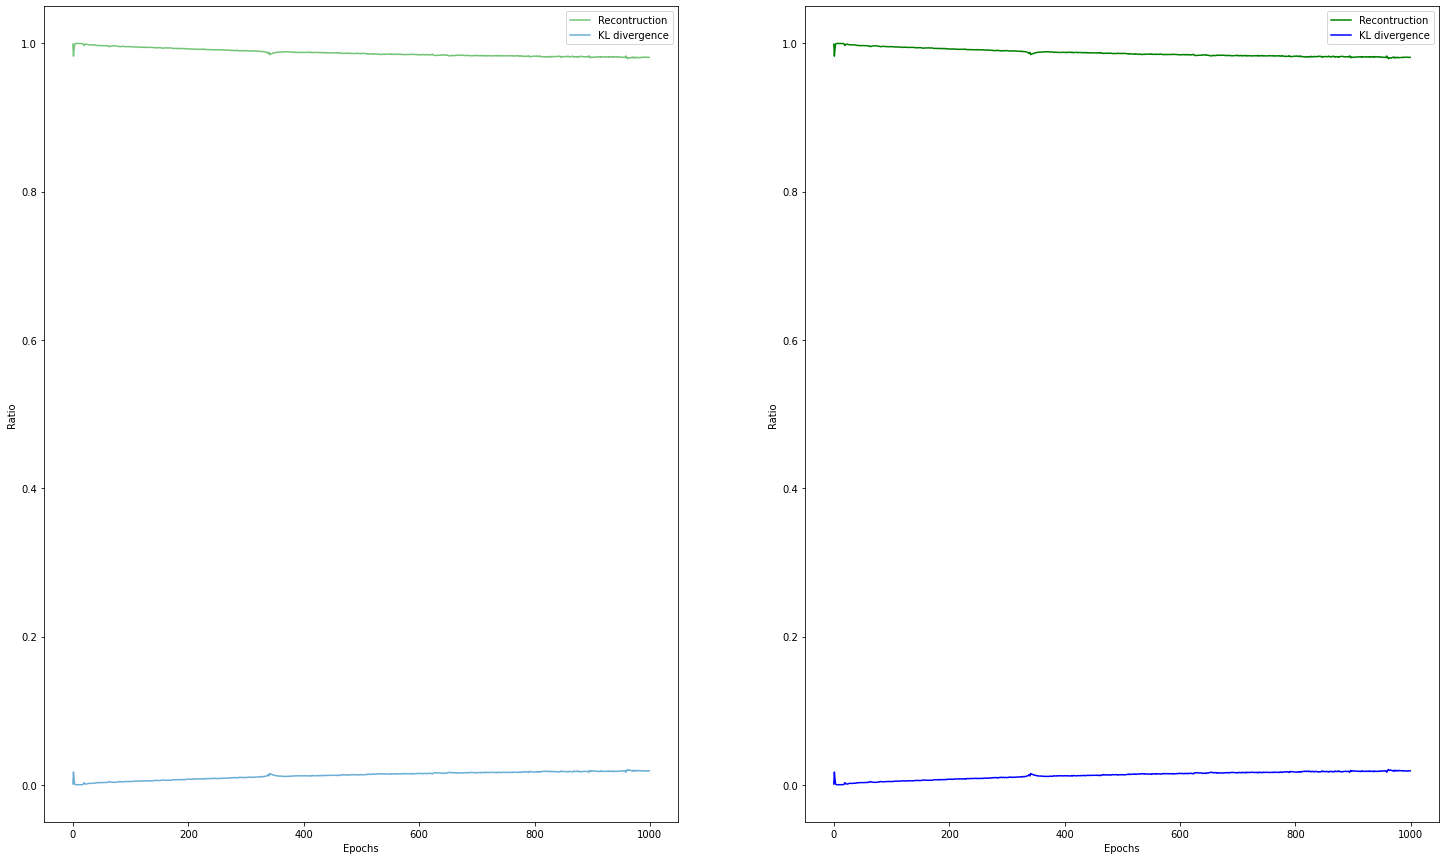

In [167]:
var_of_interest = "Transcriptional_Identity"
patient_data_cat = patient_data[var_of_interest]
labels = np.sort(np.unique(patient_data_cat))

structure = {"input dimension"        :   381,
             "hidden layers"          :   [256, 128, 64, 32],    # list of integers denoting the size of the hidden layers
             "latent dimension size"  :   2,    # integer denoting size of the latent dimension
             "activation"             :   'tanh',    # string, e.g relu/selu etc
             "dropout rate"           :   0.5,
             "learning rate"          :   0.001,
             "optimizer"              :   "adam",
             "number of clusters"     :   len(labels)}    # float, dropout is however not yet implemented, as overfitting does not seem very significant when the network structure is right

batch_size = 512

# num_patients    = data_n.shape[0]
# ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
# train_size      = int(0.80*num_patients) 

# x_train     = tf.convert_to_tensor(data_n.iloc[ind_shuffle][:train_size])
# x_test      = tf.convert_to_tensor(data_n.iloc[ind_shuffle][train_size:])

# x_train_c     = tf.convert_to_tensor(data_c.iloc[ind_shuffle][:train_size])
# x_test_c      = tf.convert_to_tensor(data_c.iloc[ind_shuffle][train_size:])

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train_c)).batch(batch_size)
# test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, x_test_c)).batch(batch_size)

train_dataset, test_dataset = data_procsg(gene_expression, patient_data, 5, batch_size, var_of_interest, balance=True)

encoder, decoder, vae       = VAE(structure)
loss_train, loss_test = training_VAE(encoder, decoder, 1000, train_dataset, test_dataset)
# encoder         = Model(inputs  = vae.input,
#                         outputs = vae.get_layer("VAE-encoder").output)
print("Train losses : total = %.4f | kl divergence  = %.4f | reconstruction = %.4f" % (loss_train[-1,0], loss_train[-1,1], loss_train[-1,2]))
print("Test losses  : total = %.4f | kl divergence  = %.4f | reconstruction = %.4f" % (loss_test[-1,0], loss_test[-1,1], loss_test[-1,2]))
means, vars, coords = encoder(gene_expression)
vis_clus(coords, patient_data, var_of_interest)
# encoder.summary()

# history = vae.fit(gene_expression, gene_expression,
#         epochs=200,
#         verbose = 0)

plot_VAE_2(loss_train, loss_test)

# **VAE (supervised clustering)**

## Building VAE

In [15]:
def sampling_sc(args):
    z_mean, z_log_sigma = args
    latent_dim = tf.shape(z_mean)
    epsilon = tf.random.normal(shape=(latent_dim[0], latent_dim[1]),
                              mean=0., stddev=0.005)
    return z_mean + tf.exp(z_log_sigma) * epsilon

In [16]:
def VAE_sc(structure):

    # K.clear_session()
    # test            = tf.keras.activations.relu(threshold=0.00001)
    input_dim       = structure["input dimension"]
    hidden_layers_e = structure["hidden layers"]
    hidden_layers_d = hidden_layers_e[::-1]
    latent_dim      = structure["latent dimension size"]

    activation      = structure["activation"]
    drop            = structure["dropout rate"]
    optimizer       = structure["optimizer"]
    lr              = structure["learning rate"]
    n_cluster       = structure["number of clusters"]      

    input_e         = Input(shape   = (input_dim,), 
                            name    = "Input")
    input_d         = Input(shape   = (latent_dim,), 
                            name    = "Input")
    
    coder_length    = len(hidden_layers_e)
    names_e         = ["Encoding_layer_"]*coder_length
    names_d         = ["Decoding_layer_"]*coder_length


    hidden_layer_e  = Dense(hidden_layers_e[0],
                            kernel_initializer  = None, #glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_e[0], 1))(input_e)
    hidden_layer_d  = Dense(hidden_layers_d[0],
                            kernel_initializer  = None, #glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_d[0], 1))(input_d)


    hidden_layers_e.pop(0)
    hidden_layers_d.pop(0)

    for i in range(len(hidden_layers_e)):
        hidden_layer_e    = Dense(hidden_layers_e[i],
                                kernel_initializer  = None, #glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_e[i], i+2))(hidden_layer_e)
        hidden_layer_d    = Dense(hidden_layers_d[i],
                                kernel_initializer  = None, #glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_d[i], i+2))(hidden_layer_d)
    
    mean        = Dense(latent_dim,
                        kernel_initializer  = None, #glorot_uniform(),
                        activation          = None,
                        name                = "z_mean")(hidden_layer_e)
    log_sigma   = Dense(latent_dim,
                        kernel_initializer  = None, #glorot_uniform(),
                        activation          = None,
                        name                = "z_log_sigma")(hidden_layer_e)
    # sigma_a = Activation(Lambda(lambda x: tf.keras.activations.relu(x, threshold=5)))(sigma)               
    z       = Lambda(sampling_sc, name = "Sampling")([mean, log_sigma])

    classification  = Dense(n_cluster,
                            kernel_initializer  = None,
                            activation          = "softmax",
                            name                = "classification_layer")(hidden_layer_e)

    output  = Dense(input_dim,
                    kernel_initializer  = None, #glorot_uniform(),
                    activation          = "linear",
                    name                = "Output")(hidden_layer_d)     

    # K.clear_session()  
    encoder     = Model(inputs  = input_e, 
                        outputs = [mean, log_sigma, z, classification], 
                        name    = "VAE-encoder")
    # encoder.layers[8].trainable = False
    decoder     = Model(inputs  = input_d, 
                        outputs = output, 
                        name    = "VAE-decoder")
    
    inputs      = Input(shape   = (input_dim,), 
                        name    = "Input")
    outputs     = decoder(encoder(input_e)[2])
    autoencoder = keras.Model(inputs    = input_e, 
                      outputs   = outputs, 
                      name      = "VAE")
    
    # reconstruction_loss = keras.losses.MeanSquaredError()
    # classification_loss = keras.losses.CategoricalCrossentropy()
    # kl_loss = 1 + 2 * log_sigma - K.square(mean) - K.square(K.exp(log_sigma))
    # kl_loss = K.sum(kl_loss, axis=-1)
    # kl_loss *= -0.5
    # vae_loss = K.mean(reconstruction_loss(input_e, outputs) + kl_loss)
    # autoencoder.add_loss(vae_loss)
    # autoencoder.compile(optimizer = optimizer)
    # autoencoder.add_loss(lambda : 10)
    # classification.add_loss(lambda : classification_loss(y_train, classification))
    encoder.compile(optimizer=optimizer)
    K.set_value(encoder.optimizer.learning_rate, lr)
    decoder.compile(optimizer=optimizer)
    K.set_value(decoder.optimizer.learning_rate, lr)
    # K.clear_session()  
    return encoder, decoder, autoencoder

## Training

### Hyperparameter tuning functions

In [ ]:
def hyperpar_tuner_VAE_sc(trial):

    K.clear_session()

    global gene_expression, models, num_labels, train_dataset, test_dataset, epochs

    # patient_data_cat    = patient_data[var_of_interest]
    # labels              = np.sort(np.unique(patient_data_cat))

    input_dim       = gene_expression.shape[1]

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    latent_dim      = 2 #trial.suggest_int("latent dimension size", 2, 15)
    activation      = trial.suggest_categorical("activation", ["relu", "selu", "tanh"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = 0 #trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 10**-2)
    # momentum        = trial.suggest_float("momentum", 0, 0.999)

    # if optimizer == "adam":
    #     optimizer   = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum, clipnorm = 1)
    # else:
    #     optimizer   = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum, clipnorm = 1)

    


    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 500)
        hidden_layers.append(hlayer)

    structure = {"input dimension"        :   input_dim,
                 "hidden layers"          :   hidden_layers,
                 "latent dimension size"  :   latent_dim,
                 "activation"             :   activation,
                 "dropout rate"           :   dropout_rate,
                 "learning rate"          :   learning_rate,
                 "optimizer"              :   optimizer,
                 "number of clusters"     :   num_labels}
    


    # data    = pd.DataFrame(gene_expression.numpy())

    # num_patients    = data.shape[0]
    # ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    # train_size      = int(0.80*num_patients) 

    # x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    # y_train     = tf.convert_to_tensor(patient_data_cat.iloc[ind_shuffle][:train_size])
    # y_train     = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(y_train)]))
    # x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])

    encoder, decoder, autoencoder       = VAE_sc(structure)

    loss_train, loss_test = training_VAE_sc(encoder, decoder, epochs, train_dataset, test_dataset)


    # autoencoder.build(input_shape=(None,input_dim))
    # autoencoder.summary()

    # history = autoencoder.fit(x                 = x_train, 
    #                           y                 = x_train,
    #                           epochs            = 200,
    #                           verbose           = 0,
    #                           validation_data   = (x_test, x_test))
    
    # trial.set_user_attr(key="history", value = history)
    trial.set_user_attr(key="test_loss", value = loss_test)
    trial.set_user_attr(key="train_loss", value = loss_train)

    result  = loss_test[-1]

    # autoencoder, train_loss, test_loss  = training_VAE_trial(autoencoder, 500, optimizer, trial)

    models.append(autoencoder)
    # result                              = test_loss[-1, 0]
    # plot_VAE(train_loss, test_loss)

    return result


In [ ]:
def find_VAE_sc(n):

    global models
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning VAE")
    study.optimize(hyperpar_tuner_VAE_sc, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    encoder     = Model(inputs  = autoencoder.input,
                            outputs = autoencoder.get_layer("VAE-encoder").output)


    # n_encoding_layers   = trial.params["N_layers"] 
    # encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    # encoder             = Sequential(encoding_layers) 

    
    # kmeans = KMeans(n_clusters= d, n_init=20)
    # kmeans.fit_predict(encoder_DEC.predict(gene_expression)[-1])
    # clustering_layer  = ClusteringLayer(d, name = "cluster")(encoder_DEC.output[-1])
    # encoder_DEC     = Model(inputs  = encoder_DEC.input,
    #                         outputs = clustering_layer)

    # encoder_DEC.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    # encoder_DEC.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return trial, autoencoder, encoder

### Training loop

In [17]:
def training_VAE_sc(encoder, decoder, epochs, train_dataset, test_dataset, w):

    @tf.function 
    def trainstep(encoder, decoder, train_data, mse, classifier, train_acc, w):

        x_train     = train_data[0]
        y_train     = train_data[1]
        y_labels    = train_data[2]

        a, b , c    = w

        with tf.GradientTape() as tape:

            (z_mean, z_log_sigma, z, classification) = encoder(x_train, training = True)
            reconstruction                           = decoder(z, training = True)

            kl_loss     = a*K.sum(K.sum(-0.5 - z_log_sigma + 0.5 * K.square(z_mean) + 0.5 * K.square(K.exp(z_log_sigma)), axis=-1), axis =-1) / 512
            r_loss      = b*mse(y_train, reconstruction)
            c_loss      = c*classifier(y_labels, classification)          

            loss        = kl_loss + r_loss + c_loss

        grads = tape.gradient(loss, [encoder.trainable_weights, decoder.trainable_weights])
        encoder.optimizer.apply_gradients(zip(grads[0], encoder.trainable_weights))
        decoder.optimizer.apply_gradients(zip(grads[1], decoder.trainable_weights))

        train_acc.update_state(y_labels, classification)

        return loss, kl_loss, r_loss, c_loss

    @tf.function
    def teststep(encoder, decoder, test_data, mse, classifier, test_acc, w):

        x_test      = test_data[0]
        y_test      = test_data[1]
        y_labels    = test_data[2]

        a, b, c    = w

        (z_mean, z_log_sigma, z, classification) = encoder(x_test, training = False)
        reconstruction                           = decoder(z, training = False)

        kl_loss     = a*K.sum(K.sum(-0.5 - z_log_sigma + 0.5 * K.square(z_mean) + 0.5 * K.square(K.exp(z_log_sigma)), axis=-1), axis =-1) / 512
        r_loss      = b*mse(y_test, reconstruction)
        c_loss      = c*classifier(y_labels, classification) 

        loss = kl_loss + r_loss + c_loss

        test_acc.update_state(y_labels, classification)

        return loss, kl_loss, r_loss, c_loss
    # print(data)
    # input_dim       = data_n.shape[1]]
    # num_patients    = data.shape[0]
    # ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    # train_size      = int(0.80*num_patients) 

    # input_dim       = data.shape[1]

    # data    = pd.DataFrame(data.numpy())
    # data    = pd.DataFrame(normalize(data).numpy())

    # num_patients    = data.shape[0]
    # ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    # train_size      = int(0.80*num_patients) 

    # x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    # x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])


    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    # optimizer = keras.optimizers.Adam(learning_rate= 0.00001, clipnorm = 1)
    mse         = keras.losses.MeanSquaredError()
    classifier  = keras.losses.CategoricalCrossentropy()
    train_acc   = keras.metrics.CategoricalAccuracy()
    test_acc    = keras.metrics.CategoricalAccuracy()
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = np.empty(shape=(epochs,4))
    loss_test   = np.empty(shape=(epochs,4))
    acc_train   = np.empty(shape=(epochs,1))
    acc_test    = np.empty(shape=(epochs,1))

    # encoder         = Model(inputs  = model.input,
    #                         outputs = model.get_layer("VAE-encoder").output)

    pgs =  tqdm(range(epochs))
    for i in pgs:

        for train_batch in train_dataset:
            train_loss      = trainstep(encoder, decoder, train_batch, mse, classifier, train_acc, w)
            loss_train[i]   = train_loss

        for test_batch in test_dataset:
            test_loss       = teststep(encoder, decoder, test_batch, mse, classifier, test_acc, w)
            loss_test[i]    = test_loss
        
        acc_train[i]    = train_acc.result()
        acc_test[i]     = test_acc.result()
        pgs.set_description("Epoch %d : training & test loss = %.4f: & %.4f | accuracy = %.4f: & %.4f" % (i,float(train_loss[0]),float(test_loss[0]), train_acc.result(), test_acc.result()))
        # train_acc.reset_states()
        # test_acc.reset_states()
    accuracy    = (acc_train, acc_test)
    return loss_train, loss_test, accuracy

### With hyperparameter tuning

[I 2021-11-16 13:55:36,944] A new study created in memory with name: Tuning VAE
Training & test loss at epoch 99: 18.7087: & 18.3968: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]
[I 2021-11-16 13:56:04,493] Trial 0 finished with value: 18.396808624267578 and parameters: {'N_layers': 2, 'activation': 'tanh', 'optimizer': 'SGD', 'learning rate': 0.00032208333864735086, 'hlay 1': 364, 'hlay 2': 16}. Best is trial 0 with value: 18.396808624267578.


 This is the best trial so far


Training & test loss at epoch 99: 7.9427: & 7.9188: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]
[I 2021-11-16 13:56:37,985] Trial 1 finished with value: 7.9188456535339355 and parameters: {'N_layers': 3, 'activation': 'tanh', 'optimizer': 'SGD', 'learning rate': 0.005283358629398397, 'hlay 1': 185, 'hlay 2': 355, 'hlay 3': 437}. Best is trial 1 with value: 7.9188456535339355.


 This is the best trial so far


Training & test loss at epoch 99: 4.7509: & 5.5948: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]
[I 2021-11-16 13:57:12,015] Trial 2 finished with value: 5.594834327697754 and parameters: {'N_layers': 4, 'activation': 'selu', 'optimizer': 'adam', 'learning rate': 0.003916666200486901, 'hlay 1': 78, 'hlay 2': 197, 'hlay 3': 464, 'hlay 4': 94}. Best is trial 2 with value: 5.594834327697754.


 This is the best trial so far


Training & test loss at epoch 99: 4.2710: & 4.4065: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
[I 2021-11-16 13:57:51,109] Trial 3 finished with value: 4.40651798248291 and parameters: {'N_layers': 5, 'activation': 'relu', 'optimizer': 'adam', 'learning rate': 0.009715130652147842, 'hlay 1': 130, 'hlay 2': 145, 'hlay 3': 417, 'hlay 4': 453, 'hlay 5': 297}. Best is trial 3 with value: 4.40651798248291.


 This is the best trial so far


Training & test loss at epoch 99: 5.1311: & 5.2158: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]
[I 2021-11-16 13:58:16,314] Trial 4 finished with value: 5.215834140777588 and parameters: {'N_layers': 1, 'activation': 'tanh', 'optimizer': 'adam', 'learning rate': 0.007098498416420798, 'hlay 1': 112}. Best is trial 3 with value: 4.40651798248291.
Training & test loss at epoch 99: 4.6518: & 4.9776: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]
[I 2021-11-16 13:58:47,540] Trial 5 finished with value: 4.977552890777588 and parameters: {'N_layers': 3, 'activation': 'selu', 'optimizer': 'adam', 'learning rate': 0.002521432616741793, 'hlay 1': 133, 'hlay 2': 98, 'hlay 3': 447}. Best is trial 3 with value: 4.40651798248291.
Training & test loss at epoch 99: nan: & nan: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]
[W 2021-11-16 13:59:15,424] Trial 6 failed, because the objective function returned [nan].
Training & test loss at epoch 99: 12.1267: & 13.1362: 100%|██████████| 100/100

Number of finished trials: 12
Best trial:
  Value: 4.40651798248291
  Params: 
    N_layers: 5
    activation: relu
    optimizer: adam
    learning rate: 0.009715130652147842
    hlay 1: 130
    hlay 2: 145
    hlay 3: 417
    hlay 4: 453
    hlay 5: 297


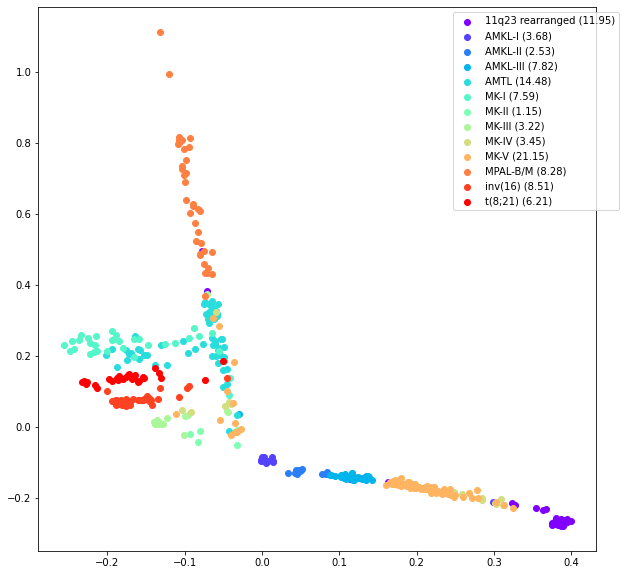

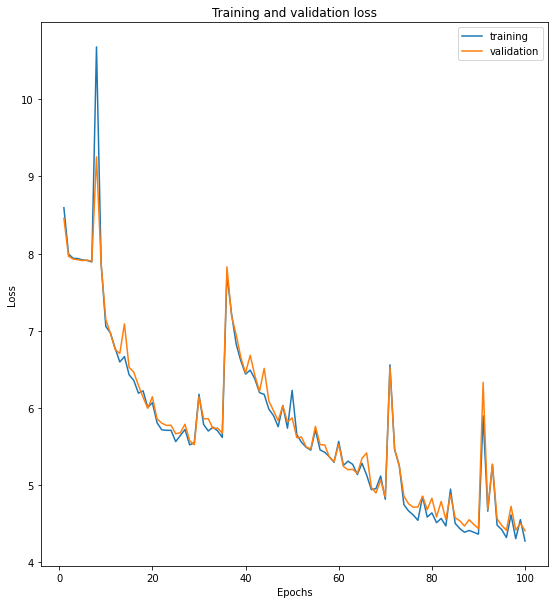

In [ ]:
var_of_interest     = "Transcriptional_Identity"
patient_data_cat    = patient_data[var_of_interest]
num_labels          = len(np.sort(np.unique(patient_data_cat)))
batch_size          = 512
epochs              = 100

train_dataset, test_dataset = data_procsg(gene_expression, patient_data, 15, batch_size, var_of_interest, balance=True)

best_trial, vae, encoder    = find_VAE_sc(12)

coords      = encoder(gene_expression)[-1]
vis_clus(coords, patient_data, var_of_interest)

loss_train  = best_trial.user_attrs["train_loss"]
loss_test   = best_trial.user_attrs["test_loss"]
plot_VAE_2(loss_train, loss_test)

### Without hyperparameter tuning

Epoch 999 : training & test loss = 1.2639: & 1.5886 | accuracy = 0.9963: & 0.9967: 100%|██████████| 1000/1000 [02:16<00:00,  7.35it/s]


Train losses : total = 1.2639 | kl divergence  = 0.0192 | reconstruction = 1.2446 | classification = 0.0000
Test losses  : total = 1.5886 | kl divergence  = 0.0221 | reconstruction = 1.5665 | classification = 0.0000


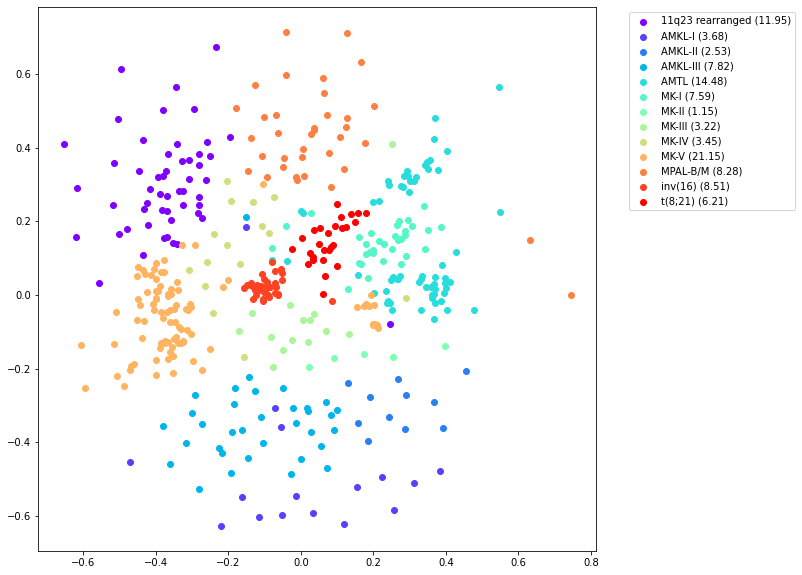

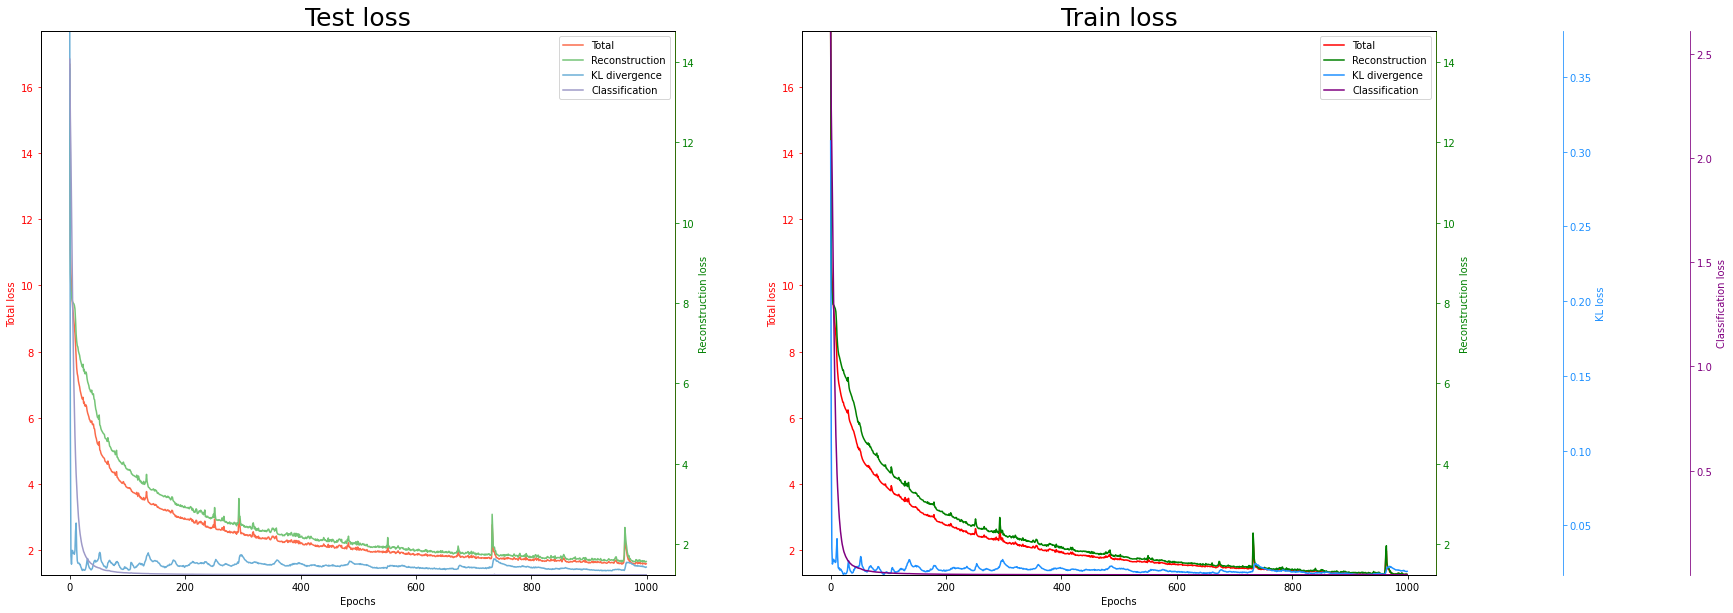

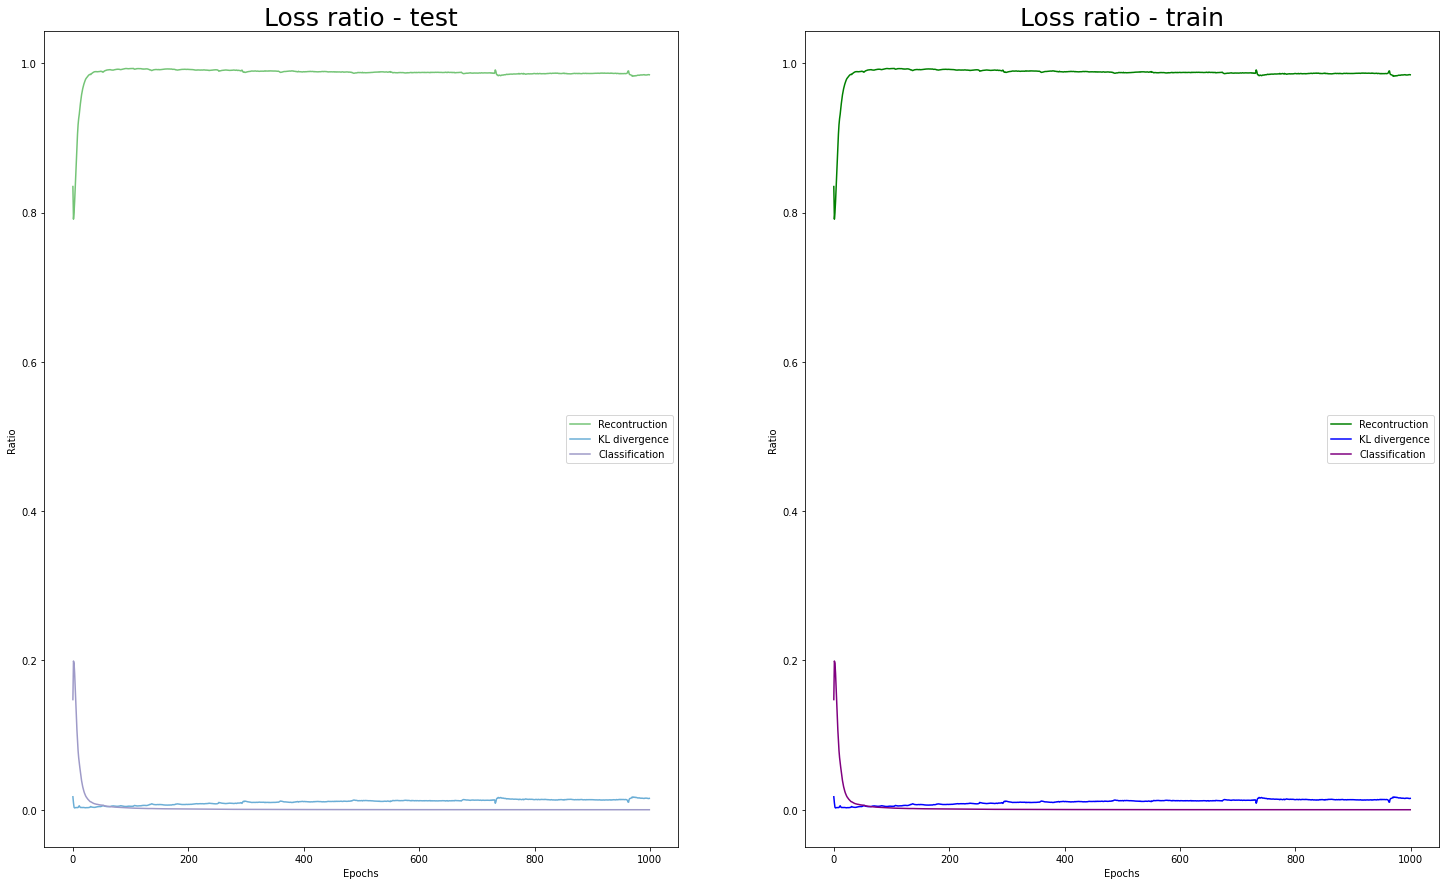

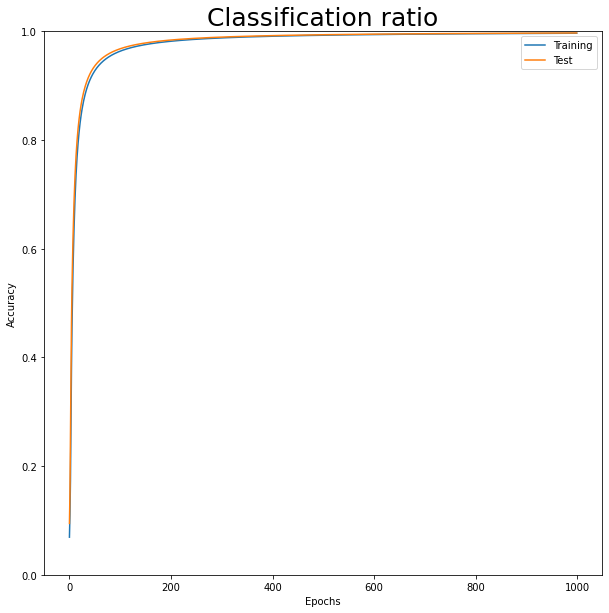

In [169]:
var_of_interest = "Transcriptional_Identity"
patient_data_cat = patient_data[var_of_interest]
labels = np.sort(np.unique(patient_data_cat))

structure = {"input dimension"        :   381,
             "hidden layers"          :   [256, 128, 64, 32],    # list of integers denoting the size of the hidden layers
             "latent dimension size"  :   2,    # integer denoting size of the latent dimension
             "activation"             :   'tanh',    # string, e.g relu/selu etc
             "dropout rate"           :   0.5,
             "learning rate"          :   0.001,
             "optimizer"              :   "adam",
             "number of clusters"     :   len(labels)}    # float, dropout is however not yet implemented, as overfitting does not seem very significant when the network structure is right

batch_size = 512
w = (1, 1, 1)

train_dataset, test_dataset = data_procsg(gene_expression, patient_data, 5, batch_size, var_of_interest, balance= True)

encoder, decoder, vae       = VAE_sc(structure)
# encoder.summary()
loss_train, loss_test, accuracy = training_VAE_sc(encoder, decoder, 1000, train_dataset, test_dataset, w)

print("Train losses : total = %.4f | kl divergence  = %.4f | reconstruction = %.4f | classification = %.4f" % (loss_train[-1,0], loss_train[-1,1], loss_train[-1,2], loss_train[-1,3]))
print("Test losses  : total = %.4f | kl divergence  = %.4f | reconstruction = %.4f | classification = %.4f" % (loss_test[-1,0], loss_test[-1,1], loss_test[-1,2], loss_test[-1,3]))
# encoder         = Model(inputs  = vae.input,
#                         outputs = vae.get_layer("VAE-encoder").output)

means, vars, coords, classifi = encoder(gene_expression)
vis_clus(coords, patient_data, var_of_interest)


# history = vae.fit(gene_expression, gene_expression,
#         epochs=200,
#         verbose = 0)

plot_VAE(loss_train, loss_test, accuracy)


In [75]:
encoder_shap         = Model(inputs  = encoder.input,
                             outputs = encoder.layers[-1].output)
background = decoder(coords, training = False).numpy()
explainer = shap.GradientExplainer(encoder_shap, background)
shap_values = explainer.shap_values(gene_expression.numpy())


/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



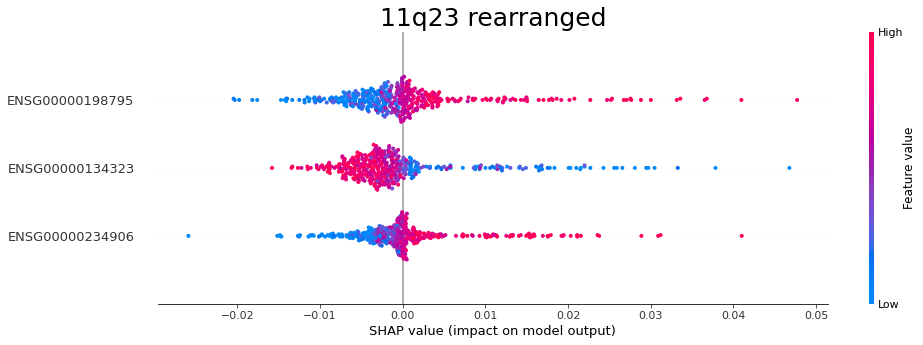

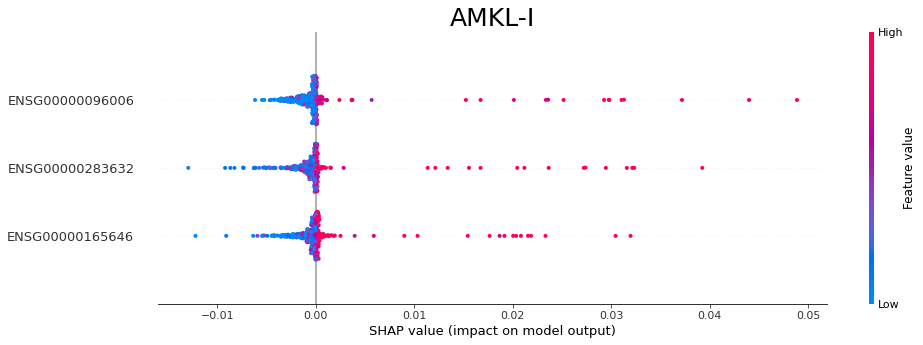

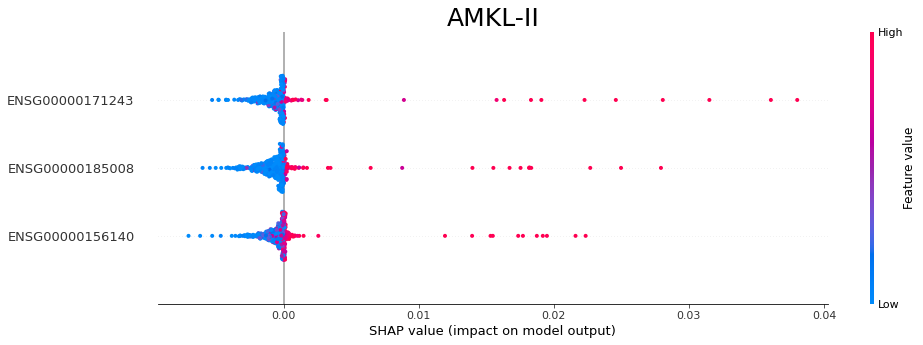

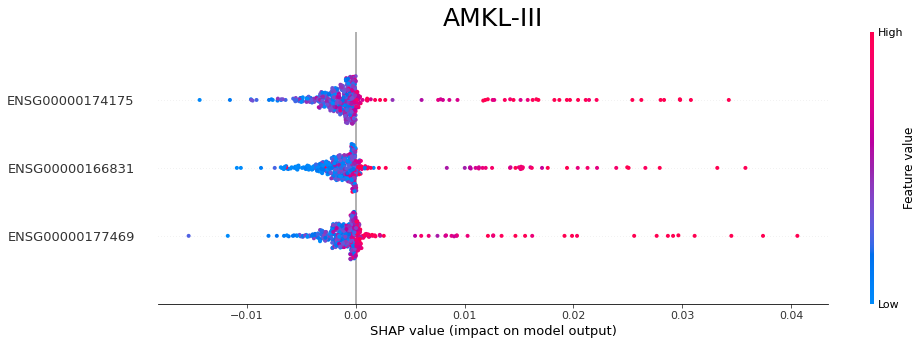

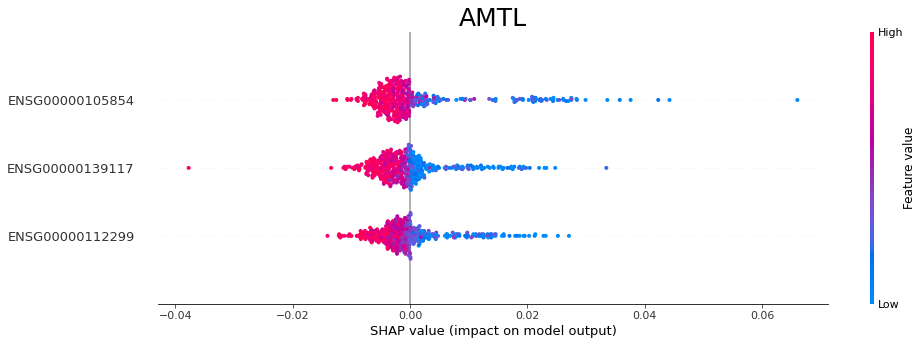

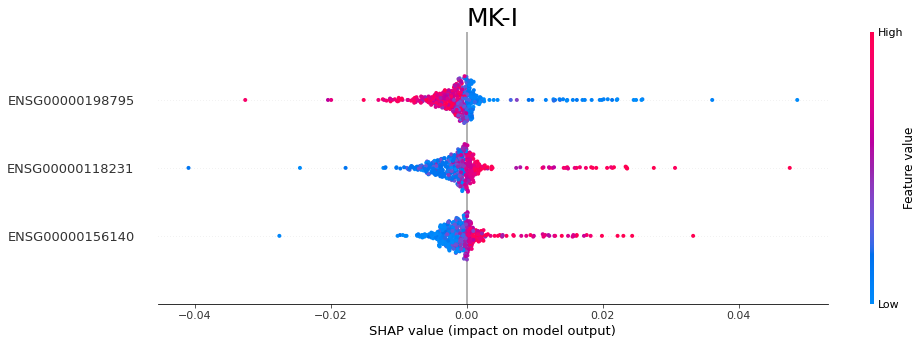

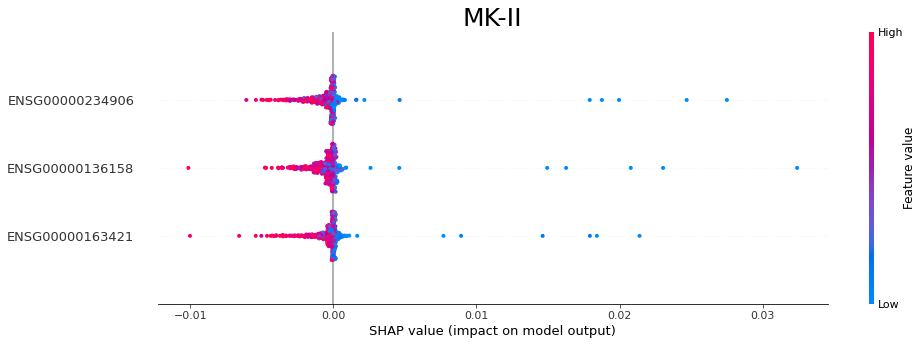

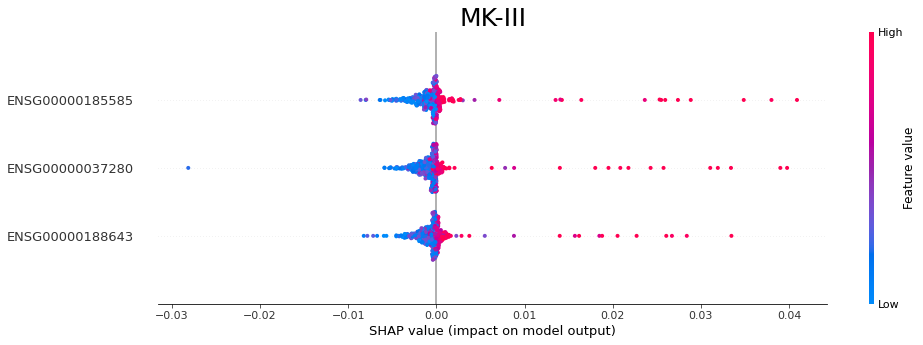

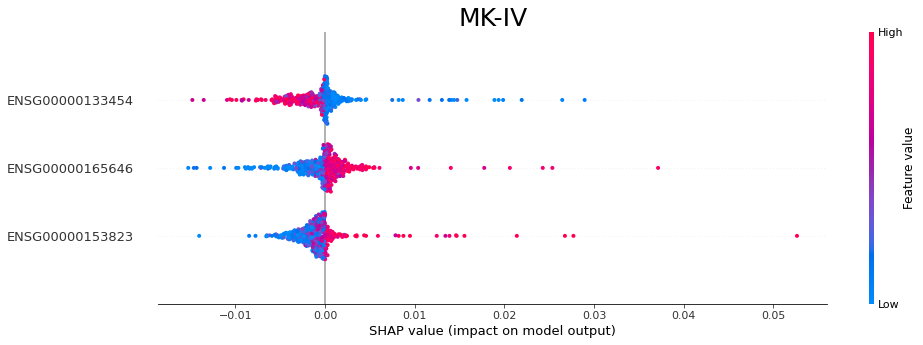

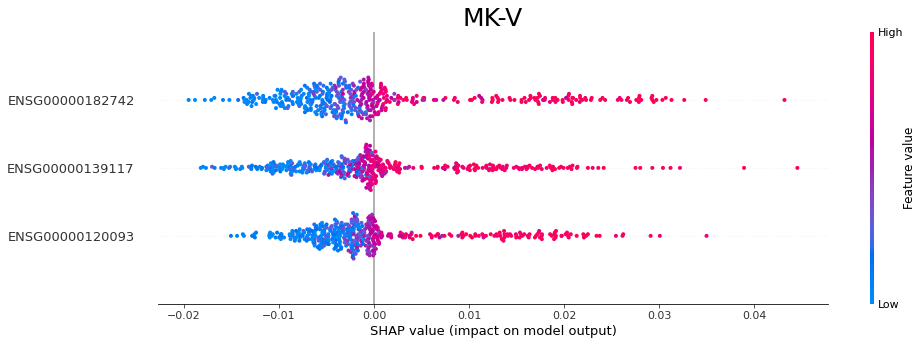

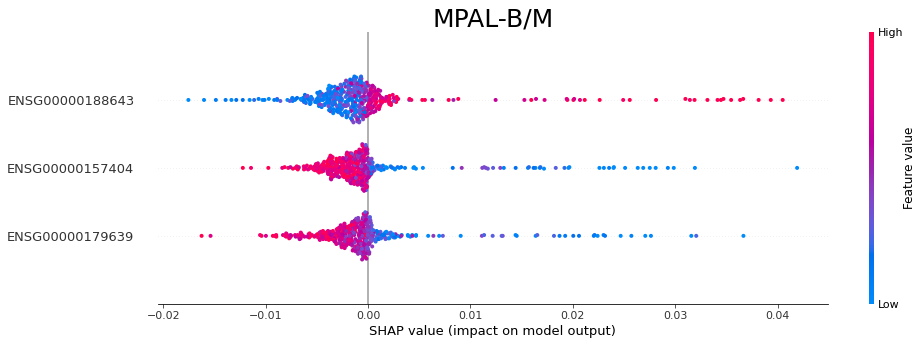

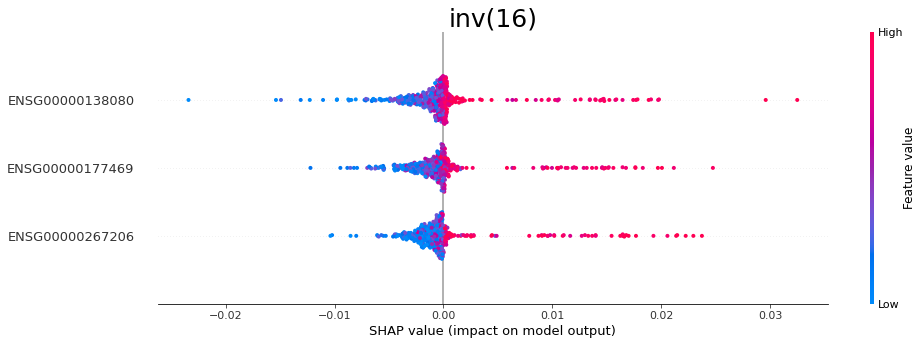

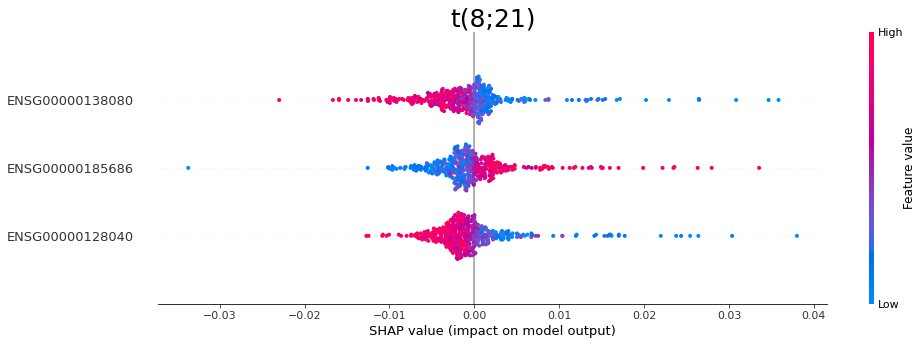

In [157]:
p_type = "dot"
f_display = 3
classes = ["AMTL"]
features = gene_expression_df
feature_names = gene_expression_df.columns

vis_shap(shap_values, p_type, f_display, labels, features, classes = None
         )